In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.Classify import SklearnClassifier
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
nltk.download('punkt')
nltk.download('popular')

[nltk_data] Downloading package punkt to /config/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /config/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /config/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /config/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /config/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /config/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /config/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /

True

# Extract Dataset

In [3]:
header = ['id', 'tweet', 'target']

tweet_df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
suicide_df = pd.read_csv('Suicide_Detection.csv', names=header, header=0, encoding='latin-1')

tweet_df = tweet_df.drop('id', axis=1)

suicide_df = suicide_df.drop('id', axis=1)
suicide_df['target'] = suicide_df['target'].map({'suicide': 1, 'non-suicide': 0})

df = pd.concat([tweet_df, suicide_df], ignore_index=True, sort=False)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
242383,If you don't like rock then your not going to ...,0
242384,You how you can tell i have so many friends an...,0
242385,pee probably tastes like salty teaðð¦â¼ï...,0
242386,The usual stuff you find hereI'm not posting t...,1


In [ ]:
df.describe()

,target
count,242388.000000
mean,0.488271
std,0.499863
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


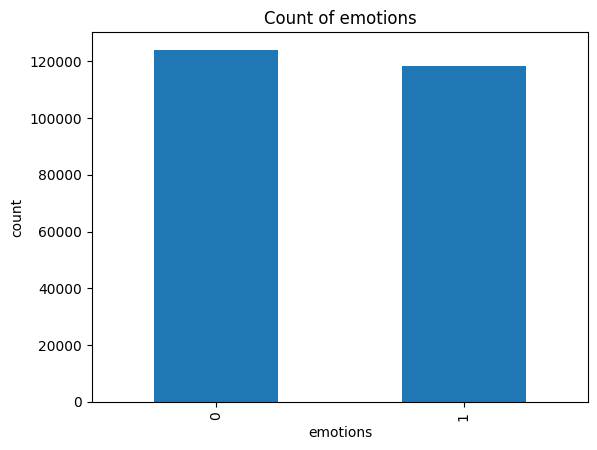

In [ ]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

## Clean Dataset

In [ ]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


# Splitting data for testing and training

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.3, random_state=100, shuffle=True)

# MNB

In [5]:
count_vect = CountVectorizer()
count_mnb_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [6]:
%%timeit -n1 -r1
yhat = count_mnb_clf.fit(x_train, y_train)

6.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
evaluation = cross_val_score(count_mnb_clf, x_train, y_train, cv=6)
print(evaluation.mean())

0.8954564927415554


In [11]:
%%timeit -n1 -r1
cross_val_score(count_mnb_clf, x_train, y_train, cv=6)

38.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
cv_result = cross_validate(count_mnb_clf, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision'], cv=6, n_jobs=-1)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())

cv_result

0.8930242978747498
0.947579852191682
0.8890853102881499
0.8444241655498104


{'fit_time': array([27.10868096, 27.17623854, 27.11918354, 26.17215085, 17.90368557,
        17.92513442]),
 'score_time': array([3.15247011, 3.15180588, 3.2431922 , 3.04064345, 3.20393968,
        3.31528997]),
 'test_f1': array([0.89516404, 0.89605047, 0.89342837, 0.88992417, 0.89477285,
        0.88880589]),
 'test_recall': array([0.9499819 , 0.94592834, 0.94817228, 0.94722745, 0.94672072,
        0.94744843]),
 'test_accuracy': array([0.89129743, 0.89278263, 0.88949397, 0.88552939, 0.89122286,
        0.88418559]),
 'test_precision': array([0.84632747, 0.85116915, 0.84466082, 0.8391586 , 0.84822934,
        0.83699962])}

## Learning Curve

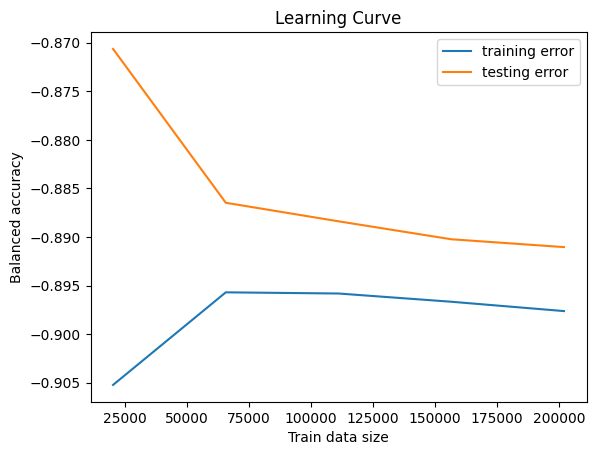

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_mnb_clf, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=6, scoring='balanced_accuracy', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()

# SVC

In [ ]:
count_vect = CountVectorizer()
count_svc_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', SVC())
])

count_svc_pipeline

Pipeline(steps=[('count_vect', CountVectorizer()), ('clf', SVC())])

In [ ]:
cv_result = cross_validate(count_svc_pipeline, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision', 'balanced_accuracy'], cv=6, n_jobs=-1)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.8829208861743773
0.8338601897784645
0.8919673896467603
0.9381236793978721
0.8906634233014281


{'fit_time': array([4221.74483204, 4129.13368154, 4101.72364306, 4171.33611751,
        4483.28495622, 4313.34479713]),
 'score_time': array([428.3322742 , 536.11007166, 442.98605132, 509.06189108,
        338.67927337, 426.5436914 ]),
 'test_f1': array([0.88259886, 0.8849402 , 0.88249732, 0.88349329, 0.88500058,
        0.87899508]),
 'test_recall': array([0.83286283, 0.83814694, 0.83286283, 0.83632547, 0.83480527,
        0.8281578 ]),
 'test_accuracy': array([0.89175713, 0.89352523, 0.89165105, 0.89224839, 0.89401655,
        0.88860598]),
 'test_precision': array([0.93865231, 0.93726728, 0.93842264, 0.93629954, 0.94161836,
        0.93648195]),
 'test_balanced_accuracy': array([0.89043584, 0.89228282, 0.89033213, 0.89099183, 0.8926861 ,
        0.88725182])}

## Learning Curve

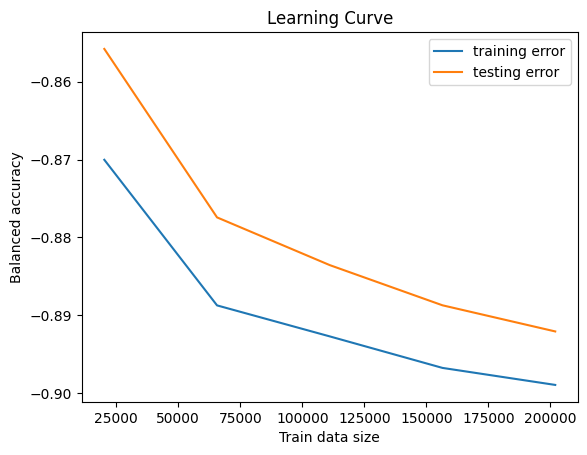

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_svc_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=6, scoring='balanced_accuracy', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()

# Random Forest Classifier

In [ ]:
count_vect = CountVectorizer()
count_rf_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

In [ ]:
cv_result = cross_validate(count_rf_pipeline, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision'], cv=6, n_jobs=-1)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())

cv_result

0.8836213968186882
0.9028689032195364
0.8838163138289837
0.8651811066659368


{'fit_time': array([5839.51693654, 5898.94877124, 5939.16407061, 5815.57417846,
        5739.60957098, 5545.03537989]),
 'score_time': array([14.16692924, 11.5299232 ,  8.82207417, 16.93779659, 17.46237874,
        23.4856863 ]),
 'test_f1': array([0.88374734, 0.88597669, 0.88353982, 0.87893171, 0.88725699,
        0.88227584]),
 'test_recall': array([0.90133912, 0.9077814 , 0.90336591, 0.89814681, 0.90524106,
        0.90133912]),
 'test_accuracy': array([0.88415432, 0.88585169, 0.88365925, 0.87912865, 0.88761581,
        0.88248815]),
 'test_precision': array([0.8668291 , 0.86519489, 0.86456529, 0.86052157, 0.86997356,
        0.86400222])}

## Learning Curve

/home/bryan/repos/sentimental_analysis/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


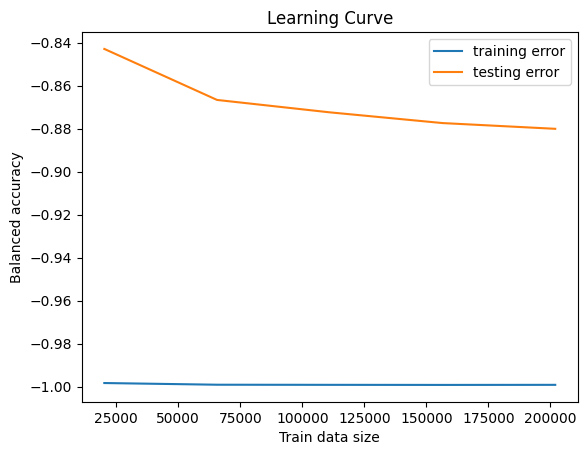

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_rf_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=6, scoring='balanced_accuracy', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()